FEATURE ENGINEERING USING OPEN SOURCE LIBRARIES

In [1]:
#data manipulation libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#for saving our pipeline
import joblib

#for data preparation and modeling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, Binarizer

#from feature-engine
from feature_engine.imputation import (
    AddMissingIndicator,
    MeanMedianImputer,
    CategoricalImputer,
)

from feature_engine.encoding import (
    RareLabelEncoder,
    OrdinalEncoder,
)

from feature_engine.transformation import (
    YeoJohnsonTransformer,
)

from feature_engine.selection import DropFeatures
from feature_engine.wrappers import SklearnTransformerWrapper

In [2]:
#load the data
df = pd.read_csv('data.csv')

print(df.shape)

df.head()

(11914, 16)


,Make,Model,Year,Engine Fuel Type,Engine HP,Engine Cylinders,Transmission Type,Driven_Wheels,Number of Doors,Market Category,Vehicle Size,Vehicle Style,highway MPG,city mpg,Popularity,MSRP
0,BMW,1 Series M,2011,premium unleaded (required),335.0,6.0,MANUAL,rear wheel drive,2.0,"Factory Tuner,Luxury,High-Performance",Compact,Coupe,26,19,3916,46135
1,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Convertible,28,19,3916,40650
2,BMW,1 Series,2011,premium unleaded (required),300.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,High-Performance",Compact,Coupe,28,20,3916,36350
3,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,"Luxury,Performance",Compact,Coupe,28,18,3916,29450
4,BMW,1 Series,2011,premium unleaded (required),230.0,6.0,MANUAL,rear wheel drive,2.0,Luxury,Compact,Convertible,28,18,3916,34500


In [41]:
df.dtypes

make                  object
model                 object
year                   int64
engine_fuel_type      object
engine_hp            float64
engine_cylinders      object
transmission_type     object
driven_wheels         object
number_of_doors       object
market_category       object
vehicle_size          object
vehicle_style         object
highway_mpg            int64
city_mpg               int64
popularity             int64
msrp                   int64
dtype: object

In [3]:
#remove the spaces and format the case of each column titles
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [4]:
#Let's create our cat vars and num vars
cat_var = [var for var in df.columns if df[var].dtype == 'object']

In [5]:
year_var = 'year'

In [6]:
num_vars = [var for var in df.columns if var not in cat_var and var not in year_var and var != 'msrp']

In [7]:
#remove the spaces and format the case of each column values

for col in cat_var:
    try:
        if df[col].dtype == 'object':
            df[col] = df[col].str.lower().str.replace(' ', '_')
        else:
            df[col] = df[col]
    except TypeError:
        print('wrong data type')
       

In [8]:
#replace na or nan with 0 in the number_of_doors variable
df['number_of_doors'] = df['number_of_doors'].fillna(0)


#number_of_doors is in actual sense supposed to be a cat var, so we first round the decimal to whole number.
#also we round the values of engine_cylinder to whole number
for i in df.index:
    df['number_of_doors'] = round(df['number_of_doors'][i])
    df['engine_cylinders'] = round(df['engine_cylinders'][i])

#update the data type for number of doors, because in reality it should be a categorical variable and not numerical
df['number_of_doors'] = df['number_of_doors'].astype('object')
df['engine_cylinders'] = df['engine_cylinders'].astype('object')

#add the new categorical variable to the list cat_var
cat_var = cat_var + ['number_of_doors', 'engine_cylinders']

Separate data into train and test data

In [9]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('msrp', axis= 1), #predictive features
                                                    df['msrp'], # target
                                                    test_size=.3,
                                                    random_state= 1,
                                                    )

x_train.shape, x_test.shape

((8339, 15), (3575, 15))

TARGET

In [10]:
y_train = np.log1p(y_train)
y_test = np.log1p(y_test)

HANDLING MISSING VALUES

In [11]:
#missing variable creation
var_with_na = [var for var in x_train.columns if x_train[var].isnull().sum() > 0]

#categorical missing variables
cat_var_na = [var for var in cat_var if var in var_with_na]
print('categorical variable with missing data: ',cat_var_na)

#numerical missing variables
num_var_na = [var for var in var_with_na if var not in cat_var_na ]
print('numerical variable with missing data: ',num_var_na)

#variables to input with the string missing
with_string_missing = [var for var in cat_var_na if x_train[var].isnull().mean()>0.1]
print('categorical variables to have their missing data replaced with missing: ', with_string_missing)

#variables to input with the most frequent categpry
with_freq_category = [var for var in cat_var_na if x_train[var].isnull().mean()<0.1]
print('categorical variables to have their missing data replaced with freq var', with_freq_category)

categorical variable with missing data:  ['engine_fuel_type', 'market_category']
numerical variable with missing data:  ['engine_hp']
categorical variables to have their missing data replaced with missing:  ['market_category']
categorical variables to have their missing data replaced with freq var ['engine_fuel_type']


HANDLING CATEGORICAL MISSING DATA

In [12]:
#replace missing values with new label - missing

#setup or instantiate the class
cat_imputer_missing = CategoricalImputer(
    imputation_method='missing', variables=with_string_missing
)

#fit the class to the train set
cat_imputer_missing.fit(x_train)

#the class learns and stores the parameter
cat_imputer_missing.imputer_dict_

{'market_category': 'Missing'}

In [13]:
#replace the NA by missing
x_train = cat_imputer_missing.transform(x_train)
x_test = cat_imputer_missing.transform(x_test)

In [14]:
#replace missing values with most freq category

#setup the class
cat_imputer_freq = CategoricalImputer(
    imputation_method='frequent', variables=with_freq_category
)

#fit the class to the train
cat_imputer_freq.fit(x_train)

#the class learns and stores the parameter
cat_imputer_freq.imputer_dict_

{'engine_fuel_type': 'regular_unleaded'}

In [15]:
#replace the NA by most frequent
x_train = cat_imputer_freq.transform(x_train)
x_test = cat_imputer_freq.transform(x_test)

In [16]:
#validate that we have no missing data in train
x_train[cat_var_na].isnull().sum()

engine_fuel_type    0
market_category     0
dtype: int64

In [17]:
#validate that we have no missing data in test
x_test[cat_var_na].isnull().sum()

engine_fuel_type    0
market_category     0
dtype: int64

HANDLING THE NUMERICAL MISSING DATA

In [18]:
#To handle missing values in numerical variables we will solve it in two ways:
# - add a binary missing indicator
# - then replace missing values in the original variable with the mean

#setup the class
missing_ind = AddMissingIndicator(variables=num_var_na)

#fit the class to the train data
missing_ind.fit(x_train)

x_train = missing_ind.transform(x_train)
x_test = missing_ind.transform(x_test)

#inspect the binary missing indicator variable
x_train.head()


,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,engine_hp_na
10660,ford,transit_connect,2016,regular_unleaded,169.0,6,automatic,front_wheel_drive,2,Missing,compact,cargo_minivan,29,21,5657,0
4140,cadillac,escalade_hybrid,2011,regular_unleaded,332.0,6,automatic,rear_wheel_drive,2,"luxury,hybrid",large,4dr_suv,23,20,1624,0
11414,chrysler,voyager,2002,flex-fuel_(unleaded/e85),180.0,6,automatic,front_wheel_drive,2,Missing,large,passenger_minivan,22,16,1013,0
5119,infiniti,g_sedan,2013,premium_unleaded_(required),328.0,6,manual,rear_wheel_drive,2,"luxury,high-performance",midsize,sedan,25,17,190,0
2639,chevrolet,c/k_1500_series,1998,regular_unleaded,200.0,6,manual,four_wheel_drive,2,Missing,large,extended_cab_pickup,19,14,1385,0


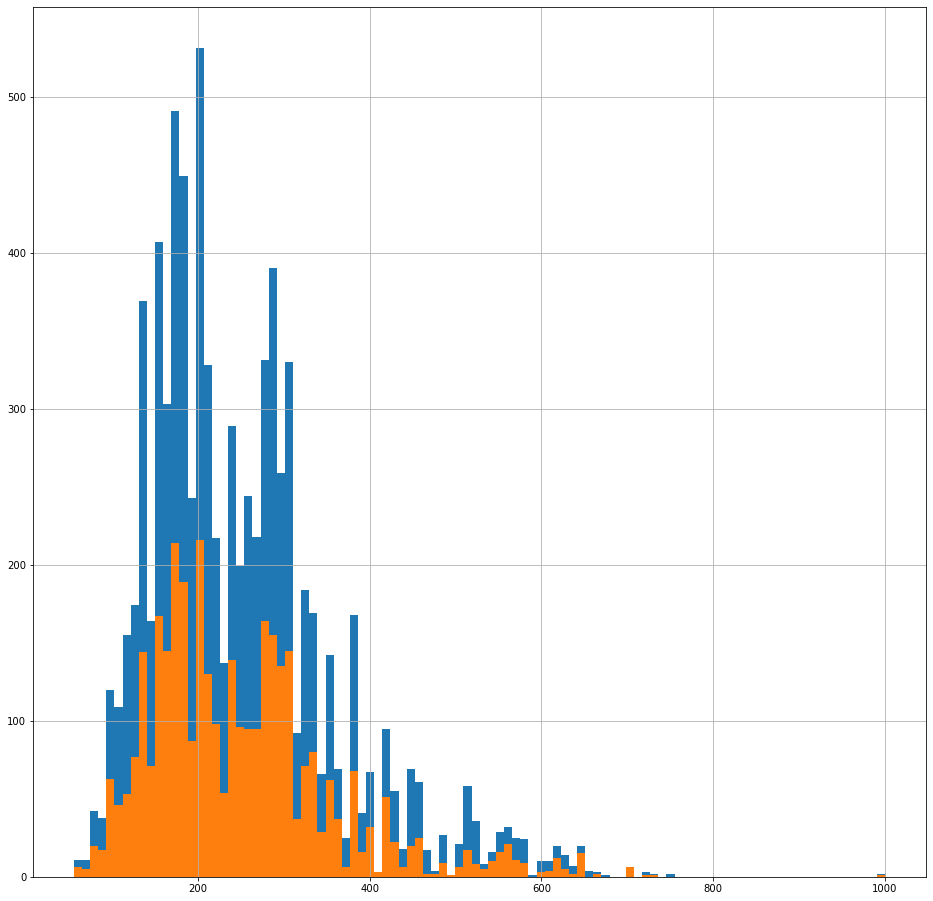

In [19]:
#investigating the distribution of engine_hp to ascertain what measure of central tendency we would use
plt.figure(figsize=(16,16))
x_train['engine_hp'].hist(bins= 100)
x_test['engine_hp'].hist(bins= 100)
plt.show()

In [20]:
#From the above, we will use the median to replace missing values as it is less likely impacted by the variance

#replacing the missing data with the median

#set the inputter by creating an instance of the class
median_inputer = MeanMedianImputer(
    imputation_method= 'median', variables= num_var_na
)

#learn and store paramters from the train set
median_inputer.fit(x_train)

#view the stored parameters
median_inputer.imputer_dict_

{'engine_hp': 225.0}

In [21]:
x_train = median_inputer.transform(x_train)
x_test = median_inputer.transform(x_test)

#check if there are still occurences of missing data
x_train[num_var_na].isnull().sum()

engine_hp    0
dtype: int64

TEMPORAL VARIABLES

In [22]:
#Two operations would be performed here, the extraction of the car age and the dropping of the year variable

def car_age(df):
    #create an empty list to hold the values 
    age = []
    for i in df['year'].index:
        age.append(df['year'].max() - df['year'][i])
    df['age'] = age

    return df

In [23]:
#let's call our function on our train and test sets respectively
x_train = car_age(x_train)
x_test = car_age(x_test)

In [24]:
x_train.head()

,make,model,year,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,engine_hp_na,age
10660,ford,transit_connect,2016,regular_unleaded,169.0,6,automatic,front_wheel_drive,2,Missing,compact,cargo_minivan,29,21,5657,0,1
4140,cadillac,escalade_hybrid,2011,regular_unleaded,332.0,6,automatic,rear_wheel_drive,2,"luxury,hybrid",large,4dr_suv,23,20,1624,0,6
11414,chrysler,voyager,2002,flex-fuel_(unleaded/e85),180.0,6,automatic,front_wheel_drive,2,Missing,large,passenger_minivan,22,16,1013,0,15
5119,infiniti,g_sedan,2013,premium_unleaded_(required),328.0,6,manual,rear_wheel_drive,2,"luxury,high-performance",midsize,sedan,25,17,190,0,4
2639,chevrolet,c/k_1500_series,1998,regular_unleaded,200.0,6,manual,four_wheel_drive,2,Missing,large,extended_cab_pickup,19,14,1385,0,19


DROP FEATURES THAT ARE INCONSEQUENCIAL

In [25]:
#Let's drop the year and model variables
drop_features = DropFeatures(features_to_drop=['year', 'model'])

x_train = drop_features.fit_transform(x_train)
x_test = drop_features.transform(x_test)


cat_var.remove('model')

In [26]:
x_train[cat_var].dtypes

make                 object
engine_fuel_type     object
transmission_type    object
driven_wheels        object
market_category      object
vehicle_size         object
vehicle_style        object
number_of_doors      object
engine_cylinders     object
dtype: object

NUMERICAL VARIABLE TRANSFORMATION

In [27]:
#Using yeo-johnson transforamtion to improve the distribution characteristics of our continuous numerical data

yeo_johnson_transformer = YeoJohnsonTransformer(
    variables= ['highway_mpg','city_mpg']
)

x_train = yeo_johnson_transformer.fit_transform(x_train)
x_test = yeo_johnson_transformer.transform(x_test)

#view the learned parameters
yeo_johnson_transformer.lambda_dict_

{'highway_mpg': -0.5981125558266324, 'city_mpg': -0.8285887515363296}

HANDLING RARE VALUES IN CATEGORICAL VARIABLES

In [28]:
#using the rare label encoder class
#create an object of the class 
rare_encoder = RareLabelEncoder(tol=0.01, n_categories=1, variables=cat_var)


#find common labels
rare_encoder.fit(x_train)

#we store our common labels in a dict and save the class
rare_encoder.encoder_dict_

/Users/eugene/opt/anaconda3/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable number_of_doors is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(
/Users/eugene/opt/anaconda3/lib/python3.9/site-packages/feature_engine/encoding/rare_label.py:182: UserWarning: The number of unique categories for variable engine_cylinders is less than that indicated in n_categories. Thus, all categories will be considered frequent
  warnings.warn(


{'make': Index(['chevrolet', 'ford', 'volkswagen', 'toyota', 'dodge', 'nissan', 'gmc',
        'honda', 'mazda', 'cadillac', 'mercedes-benz', 'suzuki', 'audi',
        'infiniti', 'bmw', 'hyundai', 'volvo', 'subaru', 'acura', 'kia',
        'mitsubishi', 'buick', 'chrysler', 'lexus', 'pontiac', 'lincoln',
        'oldsmobile', 'land_rover', 'porsche'],
       dtype='object'),
 'engine_fuel_type': Index(['regular_unleaded', 'premium_unleaded_(required)',
        'premium_unleaded_(recommended)', 'flex-fuel_(unleaded/e85)', 'diesel'],
       dtype='object'),
 'transmission_type': Index(['automatic', 'manual', 'automated_manual'], dtype='object'),
 'driven_wheels': Index(['front_wheel_drive', 'rear_wheel_drive', 'all_wheel_drive',
        'four_wheel_drive'],
       dtype='object'),
 'market_category': Index(['Missing', 'crossover', 'flex_fuel', 'luxury', 'luxury,performance',
        'hatchback', 'performance', 'crossover,luxury',
        'luxury,high-performance', 'exotic,high-performan

In [29]:
x_train = rare_encoder.transform(x_train)
x_test = rare_encoder.transform(x_test)

CATEGORICAL VARIABLE ENCODING

In [30]:
cat_var

['make',
 'engine_fuel_type',
 'transmission_type',
 'driven_wheels',
 'market_category',
 'vehicle_size',
 'vehicle_style',
 'number_of_doors',
 'engine_cylinders']

In [31]:
#setup the encoder object
cat_encoder = OrdinalEncoder(encoding_method='ordered', variables=cat_var)

#fit the model and create the mappings
cat_encoder.fit(x_train, y_train)

#save the mappings and class created
cat_encoder.encoder_dict_

{'make': {'oldsmobile': 0,
  'dodge': 1,
  'pontiac': 2,
  'mazda': 3,
  'volvo': 4,
  'suzuki': 5,
  'mitsubishi': 6,
  'buick': 7,
  'ford': 8,
  'subaru': 9,
  'chrysler': 10,
  'chevrolet': 11,
  'nissan': 12,
  'gmc': 13,
  'hyundai': 14,
  'toyota': 15,
  'honda': 16,
  'kia': 17,
  'acura': 18,
  'volkswagen': 19,
  'lincoln': 20,
  'audi': 21,
  'mercedes-benz': 22,
  'infiniti': 23,
  'lexus': 24,
  'cadillac': 25,
  'bmw': 26,
  'Rare': 27,
  'land_rover': 28,
  'porsche': 29},
 'engine_fuel_type': {'regular_unleaded': 0,
  'diesel': 1,
  'flex-fuel_(unleaded/e85)': 2,
  'premium_unleaded_(recommended)': 3,
  'Rare': 4,
  'premium_unleaded_(required)': 5},
 'transmission_type': {'manual': 0,
  'Rare': 1,
  'automatic': 2,
  'automated_manual': 3},
 'driven_wheels': {'front_wheel_drive': 0,
  'four_wheel_drive': 1,
  'rear_wheel_drive': 2,
  'all_wheel_drive': 3},
 'market_category': {'hatchback': 0,
  'Missing': 1,
  'luxury': 2,
  'hatchback,performance': 3,
  'performance':

In [32]:
x_train = cat_encoder.transform(x_train)
x_test = cat_encoder.transform(x_test)

In [33]:
#check absence of na in the train set
[var for var in x_train.columns if x_train[var].isnull().sum() >0]

[]

In [34]:
#check absence of na in the test set
[var for var in x_test.columns if x_test[var].isnull().sum() >0]

[]

OBSERVING THE MONOTONIC RELATIONSHIP BETWEEN THE LABELS AND THE TARGET VARIABLE

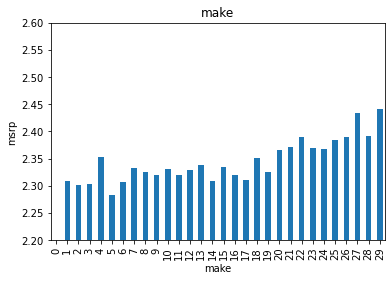

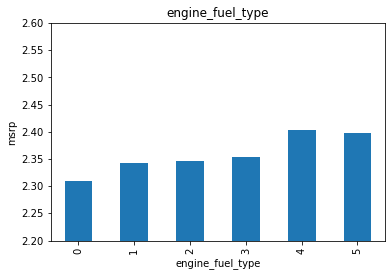

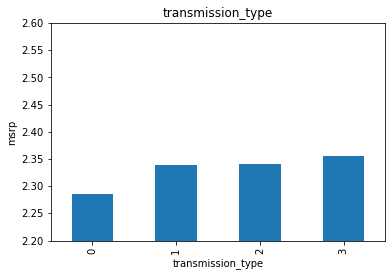

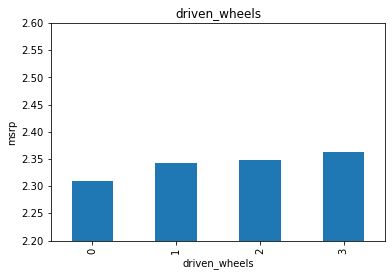

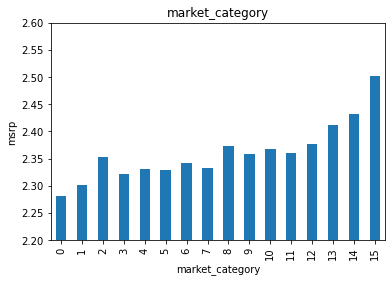

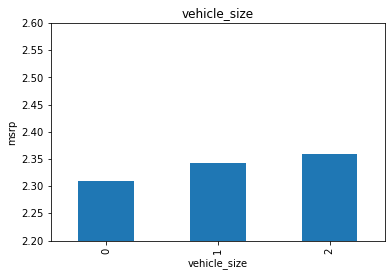

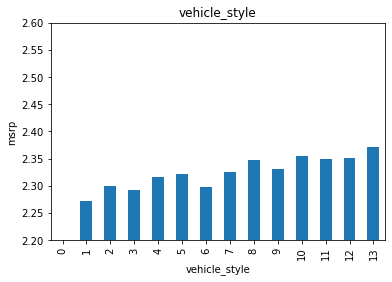

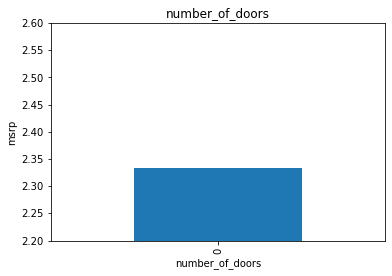

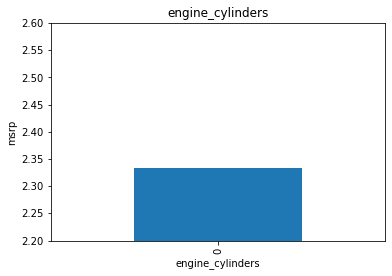

In [35]:
 #let me show you what I mean by monotonic relationship
# between labels and target

def analyse_vars(X_train, y_train, var):
    
    # function plots median car msrp per encoded
    # category
    
    tmp = pd.concat([X_train, np.log(y_train)], axis=1)
    
    tmp.groupby(var)['msrp'].median().plot.bar()
    plt.title(var)
    plt.ylim(2.2, 2.6)
    plt.ylabel('msrp')
    plt.show()
    
for var in cat_var:
    analyse_vars(x_train, y_train, var)

FEATRUE SCALING

In [36]:
#create our scalar object
scalar = MinMaxScaler()

#fit the scalar to the train set to learn our data
scalar.fit(x_train)

#transform the train and the test set and wrap it back to a dataframe
x_train = pd.DataFrame(scalar.transform(x_train), columns= x_train.columns)
x_test = pd.DataFrame(scalar.transform(x_test), columns= x_test.columns)

In [37]:
x_train.head()

,make,engine_fuel_type,engine_hp,engine_cylinders,transmission_type,driven_wheels,number_of_doors,market_category,vehicle_size,vehicle_style,highway_mpg,city_mpg,popularity,engine_hp_na,age
0,0.275862,0.0,0.120507,0.0,0.666667,0.000000,0.0,0.066667,0.0,0.153846,0.456760,0.626706,1.000000,0.0,0.037037
1,0.862069,0.0,0.292812,0.0,0.666667,0.666667,0.0,0.733333,1.0,0.846154,0.356272,0.607937,0.286826,0.0,0.222222
2,0.344828,0.4,0.132135,0.0,0.666667,0.000000,0.0,0.066667,1.0,0.538462,0.335536,0.512956,0.178780,0.0,0.555556
3,0.793103,1.0,0.288584,0.0,0.000000,0.666667,0.0,0.933333,0.5,0.692308,0.393869,0.540310,0.033245,0.0,0.148148
4,0.379310,0.0,0.153277,0.0,0.000000,0.333333,0.0,0.066667,1.0,0.307692,0.263606,0.448335,0.244562,0.0,0.703704


In [38]:
# let's now save the train and test sets

x_train.to_csv('xtrain.csv', index_label=False)
x_test.to_csv('xtest.csv', index_label=False)

y_train.to_csv('ytrain.csv', index_label=False)
y_test.to_csv('ytest.csv', index_label=False)

In [39]:
joblib.dump(scalar, 'minmax_scalar.joblib')

['minmax_scalar.joblib']